# CR Hamiltonian Tomography Demo

This is a very basic implemention of a CR Hamiltonian tomohraphy experiment.

### Note
This experiment uses [pulse gates](https://qiskit.org/documentation/tutorials/circuits_advanced/05_pulse_gates.html), which is not supported by simulators.
To run this experiment, you need to have access to one of backends with more than two qubits and supporting pulse gate experiment.

In [1]:
import numpy as np
import qiskit_experiments as qe

from qiskit import circuit, pulse, IBMQ

In [2]:
IBMQ.load_account()

hub = ""
group = ""
project = ""

provider = IBMQ.ibmq.get_provider(hub, group, project)
backend = provider.backend.ibmq_mumbai

### Running default CR pulse (single CR pulse)

Tips: To obtain good experimental result.

You need to choose sufficiently long pulse durations, otherwise we cannot analyze the result data. On the other hand, there is the maximum waveform memory limitations per job, thus scanning over very long pulses may quickly populate the memory and cause an error. Thus you need to find the best combination of the scan range and number of points, which depends on the coupling rate and drive strength (`amp`) of cross resonance pulses.

---------------------------------------------------
Experiment: CRHamiltonianTomography
Experiment ID: 6a74a105-28a5-4460-a62d-fbe041cd6346
Status: DONE
Circuits: 180
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- px0: -2975205.1642569806 ± 352.0656700784941
- py0: -4777944.03120857 ± 240.48550827631962
- pz0: -107007.89255960153 ± 299.14487480895934
- px1: 5170737.196493598 ± 654.331048715126
- py1: 8348574.639277422 ± 409.5257267464761
- pz1: 440687.2948557735 ± 542.4211349995627
- b: 0.012343124855480161 ± 1.4491565453674514e-05
- analysis_type: CRHamiltonianAnalysis
- reduced_chisq: 61943.874740745574
- dof: 173
- xrange: [3.564982435030756e-08, 9.245387132391964e-07]
- ZX: -648233.496427559
- ZX_err: 59.12875800738557
- ZY: -1044575.1659979499
- ZY_err: 37.792563663942175
- ZZ: -43584.19819239948
- ZZ_err: 49.293625075377356
- IX: 174714.88782352605
- IX_err: 59.12875800738557
- IY: 284141.75561468885
- IY_err: 37.792563663942175
- I

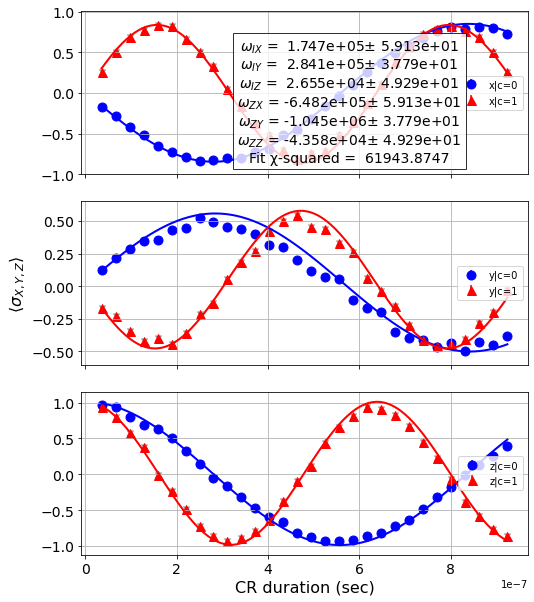

In [5]:
qubits = 0, 1
sigma = 64
amp = 0.4
risefall = 2
durations = np.linspace(0, 4000, 30) + 2 * risefall * sigma

exp_cr1 = qe.hamiltonian_tomography.CRHamiltonianTomography(
    qubits=qubits,
    durations=durations,
)
exp_cr1.set_experiment_options(
    amp=amp,
    sigma=sigma,
    risefall=risefall,
)
exp_data1 = exp_cr1.run(backend)

print(exp_data1)

### Running Echoed CR pulse

ECR usually removes some unwanted terms such as $IX$ and $ZI$. See the effect of echoing with CR Hamiltonian tomography.

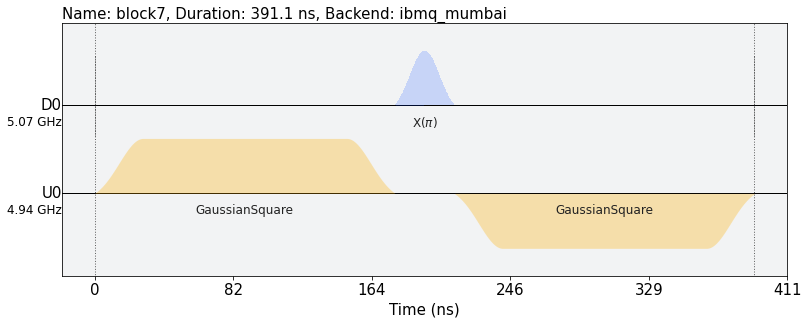

In [10]:
dur = circuit.Parameter("duration")

with pulse.build(backend, default_alignment="sequential") as ecr_sched:
    pulse.barrier(*qubits)
    pulse.play(
        pulse.GaussianSquare(dur, amp, sigma, dur - 2 * risefall * sigma),
        pulse.control_channels(*qubits)[0]
    )
    pulse.x(qubits[0])
    pulse.play(
        pulse.GaussianSquare(dur, -amp, sigma, dur - 2 * risefall * sigma),
        pulse.control_channels(*qubits)[0]
    )
    pulse.barrier(*qubits)

# Draw ECR schedule at duration = 800
ecr_sched.assign_parameters({dur: 800}, inplace=False).draw(backend=backend)

---------------------------------------------------
Experiment: CRHamiltonianTomography
Experiment ID: 60b54c85-75d1-4616-8321-dc29925c41a3
Status: DONE
Circuits: 180
Analysis Results: 1
---------------------------------------------------
Last Analysis Result
- px0: -4103926.2228050297 ± 646.672713167883
- py0: -8045758.011701616 ± 348.1929691405629
- pz0: 782874.1817287891 ± 502.5249084086798
- px1: 4565987.8782690475 ± 618.0724938111742
- py1: 7774602.517252317 ± 367.87613151067814
- pz1: 651397.7018696477 ± 478.60424512490766
- b: -0.027219439697220574 ± 1.6451530617315734e-05
- analysis_type: CRHamiltonianAnalysis
- reduced_chisq: 443032.6377699801
- dof: 173
- xrange: [7.129964870061511e-08, 9.60188537589504e-07]
- ZX: -689929.8426840329
- ZX_err: 71.18511548121715
- ZY: -1258944.2898394652
- ZY_err: 40.30826284030048
- ZZ: 10462.565834952184
- ZZ_err: 55.224317504707145
- IX: 36769.69824016135
- IX_err: 71.18511548121715
- IY: -21577.868644066504
- IY_err: 40.30826284030048
- IZ:

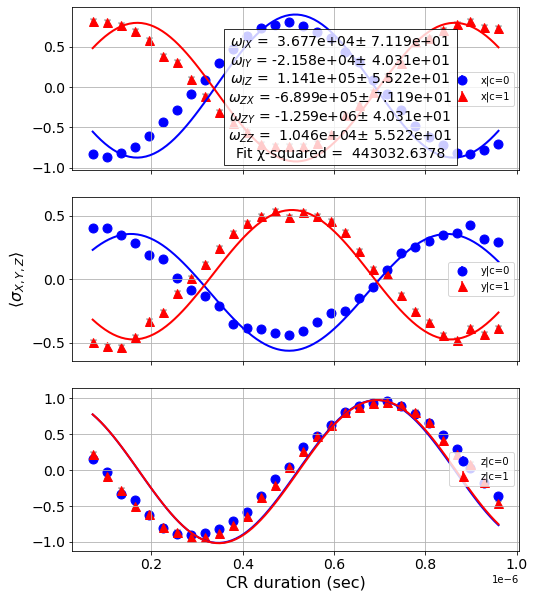

In [11]:
widths = np.linspace(0, 2000, 30)
durations = widths + 2 * 2 * risefall * sigma

# Net CR interaction durations, considering Gaussian pulse edges of two CR pulses.
x_values = 2 * (widths + np.sqrt(2 * np.pi * sigma ** 2)) * backend.configuration().dt

exp_cr2 = qe.hamiltonian_tomography.CRHamiltonianTomography(
    qubits=qubits,
    durations=durations,
    cr_gate_schedule=ecr_sched,
    x_values=x_values,
)
exp_data2 = exp_cr2.run(backend)

print(exp_data2)

IX supression estimated by ECR

In [14]:
exp_data2.analysis_result(0)["IX"] / exp_data1.analysis_result(0)["IX"]

0.21045543798935584